In [18]:
pwd()

"/Users/kyan/Projects/qgplsim"

# Start

In [24]:
# run this ceil if source codes was edited
include("DGP.ji")
# include("qgplsim.ji")
include("MonteCarloSIM.ji")
using Statistics, LinearAlgebra, Clustering
using LaTeXStrings, Plots

import Base.Threads.@threads

# QGPLSIM fitting

In [28]:
# run this ceil for different data sets

α = [1.0, 2.0] # single index for x
θ = [2.0, -1.0]  # linear for x, <α, θ> = 0 for identification
γ = [0.5, 1.0] # single index for z
β = [-1.0, -0.5] # linear for z
# Q(y|x, z) = Xθ + Zβ + g(Xα + Zγ)

n = 600
fx = 2 # y = f(x), fx for different f(x)     
                # fx = 1, y = X*θ + Z*β + (X*α + Z*γ .- 1).^2 + 0.2ϵ
                # fx = 2, y = X*θ + Z*β + log.(1 .+ exp.(X*α + Z*γ .- 1)) + 0.2ϵ

ifz = true # if false, Z = 0, i.e. no category varible
dist = 1 # 0 for gauss, 1 for Cauchy
X, Z, y = dgp(n, γ, θ, α, β, fx, dist,  ifz)
# p = length(α)
# q = length(γ)
τ = 0.5

# Estimation 

model1 = qgplsim.model(X, Z, y, τ)
alpha_type = 1
# different weight of sum on alpha 
# 0 for true alpha, using α in DGP
# 1 for global: ∑ij sum(Bi - Bj) / n;
# 2 for local: ∑z ∑ij (bzi - bzj) * nz / n;
# when Z = 0, global == local
@time alpha1, gamma, theta, beta, squ = qgplsim.estimator(model1, alpha_type)
coefa = 1 #/ alpha[1]
coefg = 1 #/ gamma[1]
println("Estimation of index coefs: ")
println("̂α => ", coefa * alpha1)
println("̂γ => ", gamma)

println("Estimation of linear coefs: ")
println("̂θ => ", theta)
println("̂β => ", beta)

println("square of integral: ", squ)

# theta * alpha

  2.256529 seconds (3.14 M allocations: 19.532 GiB, 21.51% gc time)
Estimation of index coefs: 
̂α => [0.5607369191718954; 0.8279940262330466]
̂γ => [0.1967806273789764, 0.36914201412744047]
Estimation of linear coefs: 
̂θ => [1.7313715147883868 -1.1725252820497583]
̂β => [-0.4563773761002767, -0.21468494091066725]
square of integral: 4.8508164570257355


# Paths of $g(x \alpha + z \gamma)$ and $\nabla g$

$\alpha = \hat{\alpha}$,
$z \in S_z$

In [4]:
model1.index

Dict{Vector{Float64}, Vector{Int64}} with 6 entries:
  [1.0, 0.0] => [2, 16, 17, 23, 26, 27, 39, 56, 74, 93  …  219, 239, 248, 251, …
  [0.0, 1.0] => [4, 8, 9, 12, 15, 18, 22, 25, 28, 32  …  256, 259, 260, 272, 27…
  [1.0, 2.0] => [1, 24, 29, 45, 49, 54, 57, 75, 77, 79  …  232, 234, 237, 238, …
  [0.0, 2.0] => [5, 14, 20, 30, 37, 64, 69, 86, 89, 104  …  228, 230, 241, 257,…
  [1.0, 1.0] => [3, 7, 11, 13, 19, 21, 41, 42, 43, 44  …  276, 278, 282, 284, 2…
  [0.0, 0.0] => [6, 10, 31, 33, 35, 36, 40, 50, 53, 67  …  195, 196, 202, 214, …

In [29]:
g = zeros(n)
dg = zeros(n)
v = X * alpha1 
yz = y - X * transpose(theta)
categ, index = model1.categ, model1.index
z = collect(index)
ncateg = index.count
width = zeros(ncateg)
v0 = -1e6
v1 = 1e6

for k in 1:ncateg
    vk = v[z[k][2]]
    h = (length(vk))^(-0.17) * var(vk)
    width[k] = h

    dgk(u) = qgplsim.Gz(u, vk, yz[z[k][2]], 1, τ)
    gk(u) = qgplsim.Gz(u, vk, yz[z[k][2]], 0, τ)

    dg[z[k][2]] = dgk(vk)
    g[z[k][2]] = gk(vk)

    vkmin = minimum(vk) + h
    vkmax = maximum(vk) - h

    if  vkmin > v0
        v0 = vkmin
    end
    if  vkmax < v1
        v1 = vkmax
    end  
end

# g, dg = qgplsim.G(v, Z, yz, τ, -0.4) # g: g(v), dg: g'(v)

println(width)
# v0, v1 = v0 + h, v1 - h
v0, v1

[1.061592163525241, 1.6757147678460744, 1.6580045479757421, 1.4081177426606222, 1.1052027852574395, 1.2468087460359911]


(-2.172979263438875, 1.7797808354542806)

In [30]:
v_ = v[v .> v1]
_v = v[v .< v0]

v_ = minimum(v_)
_v = maximum(_v)

_v, v_

(-2.24914127267711, 1.7810728179896727)

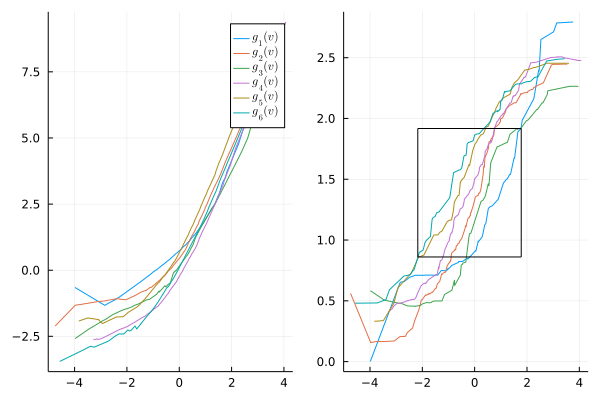

In [31]:
C0 = zeros(ncateg)
C1 = zeros(ncateg)
dgf(vv, k) = qgplsim.Gz(vv, v[z[k][2]], yz[z[k][2]], 1, τ)


p1 = plot()
p2 = plot()
for m in 1:ncateg
    C0[m] = dgf(_v, m)[1]
    C1[m] = dgf(v_, m)[1]

    vm = v[index[categ[m]]]
    dgm = dg[index[categ[m]]]
    gm = g[index[categ[m]]]
    indm = sortperm(vm)
    sorted_dgm = dgm[indm]
    sorted_gm = gm[indm]
    sorted_vm = vm[indm]
    plot!(p1, sorted_vm, sorted_gm, label = L"g_{%$m} (v)")
    plot!(p2, sorted_vm, sorted_dgm, label = false )# L"\nabla g_{%$m} (v)")

end

c0 = maximum(C0)
c1 = minimum(C1)
plot!(p2, [v0, v0], [c0, c1], color = "black", label = false)
plot!(p2, [v1, v1], [c0, c1], color = "black", label = false)
plot!(p2, [v0, v1], [c0, c0], color = "black", label = false)
plot!(p2, [v0, v1], [c1, c1], color = "black", label = false)


plot(p1, p2, layout = (1,2))

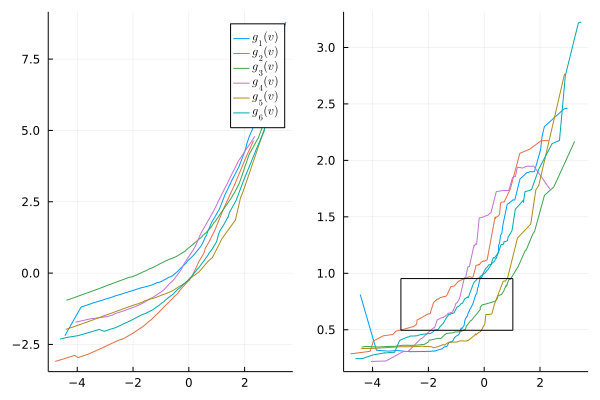

In [53]:
C0 = zeros(ncateg)
C1 = zeros(ncateg)
dgf(vv, k) = qgplsim.Gz(vv, v[z[k][2]], yz[z[k][2]], 1, τ)


p1 = plot()
p2 = plot()
for m in 1:ncateg
    C0[m] = dgf(v0, m)[1]
    C1[m] = dgf(v1, m)[1]

    vm = v[index[categ[m]]]
    dgm = dg[index[categ[m]]]
    gm = g[index[categ[m]]]
    indm = sortperm(vm)
    sorted_dgm = dgm[indm]
    sorted_gm = gm[indm]
    sorted_vm = vm[indm]
    plot!(p1, sorted_vm, sorted_gm, label = L"g_{%$m} (v)")
    plot!(p2, sorted_vm, sorted_dgm, label = false )# L"\nabla g_{%$m} (v)")

end

c0 = maximum(C0)
c1 = minimum(C1)
plot!(p2, [v0, v0], [c0, c1], color = "black", label = false)
plot!(p2, [v1, v1], [c0, c1], color = "black", label = false)
plot!(p2, [v0, v1], [c0, c0], color = "black", label = false)
plot!(p2, [v0, v1], [c1, c1], color = "black", label = false)


plot(p1, p2, layout = (1,2))

In [79]:
[C0 C1]

6×2 Matrix{Float64}:
 0.468544  1.43035
 0.464025  1.78102
 0.874062  1.93499
 1.21755   2.08242
 0.928761  1.96797
 0.781526  1.62276

# Monte Carlo Simulation

In [32]:
Threads.nthreads()

2

In [1]:
include("MonteCarloSIM.ji")

main (generic function with 4 methods)

In [19]:
α = [1.0, -1.5] # single index for x
θ = [2.0, 1.0]  # linear for x, <α, θ> = 0 for identification
γ = [0.5, 1.0] # single index for z
β = [-1.0, -0.5] # linear for z
τ = 0.5
# Q(y|x, z) = Xθ + Zβ + g(Xα + Zγ)
n = 600
fx = 2
dist = 1 # Cauchy
rep = 50 # MC rept. times

50

In [20]:
Alpha, Gamma, Theta, Beta, Squ = MonteCarlo(n, γ, θ, α, β, τ, fx, dist, rep)

([0.6181126998971146 -0.7860894925044473; 0.5934283037086393 -0.804886854382333; … ; 0.59939117214403 -0.8004562591146412; 0.4796894682726746 -0.8774383249142237], [0.21529186583674342 0.5356813886460028; 0.20497076456716512 0.38985243090359933; … ; 0.1714251481681497 0.4560272488259673; 0.18666656913539448 0.46053246235943174], [1.6713283509044066 1.3141878745902082; 1.7527631435114233 1.2922800930264973; … ; 1.7203803806320142 1.2882413013062965; 2.0214410026276113 1.1051078259999791], [-0.3634154471148135 -0.28950342536670864; -0.34442326294943637 -0.2183445257384188; … ; -0.34813886030948854 -0.2747658180913474; -0.703085235498099 -0.28365315719552636], [2.0268175327820943, 4.047512968963968, 1.386244933332676, 5.032143950544373, 2.5540199265729404, 2.37099763004398, 1.6445151473573014, 0.9317208159063559, 3.235044503021803, 1.8686134235182021  …  1.7627861336952757, 2.1117332436705447, 2.412838649696391, 2.097191365321943, 3.075249672568385, 1.4212816164520474, 1.859798634119196, 

In [21]:
mb = mean(Beta, dims = 1)

1×2 Matrix{Float64}:
 -0.519661  -0.213284

In [22]:
median(Beta, dims = 1)

1×2 Matrix{Float64}:
 -0.465525  -0.225716

In [6]:

p1 = histogram(Beta[:,1], bins = -1:0.1:3, label = "b1")
p2 = histogram(Beta[:,2], bins = -2:0.1:2, label = "b2")
plot(p1, p2, layout = (1, 2))

LoadError: UndefVarError: histogram not defined

In [23]:
mg = mean(Gamma, dims = 1)

1×2 Matrix{Float64}:
 0.215642  0.456713

In [17]:
median(Gamma, dims = 1)

1×2 Matrix{Float64}:
 0.166183  0.342703

In [18]:
(γ |> transpose) ./ mg

1×2 Matrix{Float64}:
 2.77627  2.84222

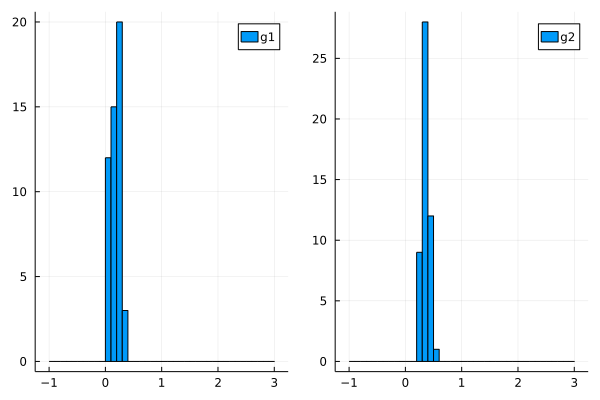

In [85]:
p1 = histogram(Gamma[:,1], bins = -1:0.1:3, label = "g1")
p2 = histogram(Gamma[:,2], bins = -1:0.1:3, label = "g2")
plot(p1, p2, layout = (1, 2))

In [69]:
ma = mean(Alpha, dims = 1)

1×2 Matrix{Float64}:
 0.448198  -0.866288

In [70]:
mt = mean(Theta, dims = 1)

1×2 Matrix{Float64}:
 1.97497  0.919727

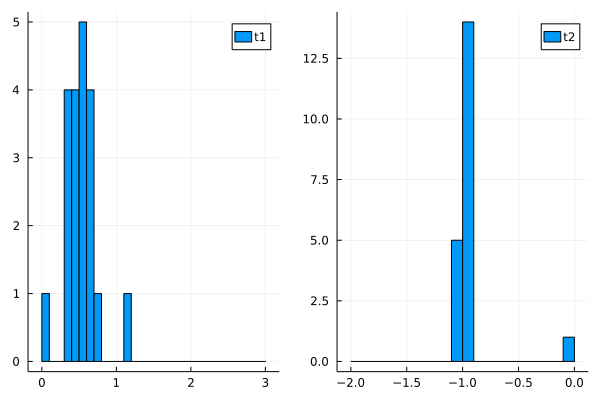

In [91]:
p1 = histogram(Theta[:,1], bins = 0:0.1:3, label = "t1")
p2 = histogram(Theta[:,2], bins = -2:0.1:-0, label = "t2")
plot(p1, p2, layout = (1, 2))

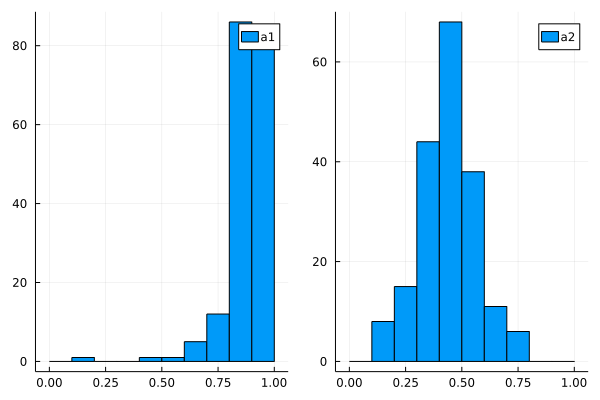

In [35]:
p1 = histogram(Alpha[:,1], bins = 0:0.1:1, label = "a1")
p2 = histogram(Alpha[:,2], bins = 0:0.1:1, label = "a2")
plot(p1, p2, layout = (1, 2))